# Seattle Lidar

## Visualize Lidar Scattered Point Elevation Data

This notebook uses Datashader to visualize Lidar elevation data from [the Puget Sound Lidar consortium](http://pugetsoundlidar.ess.washington.edu/), a source of Lidar data for the Puget Sound region of the state of Washington, U.S.A.

### Lidar Elevation Data

Example X,Y,Z scattered point elevation data from the unpacked 7zip files (unpacked as .gnd files)

```
! head ../data/q47122d2101.gnd
```
```
X,Y,Z
1291149.60,181033.64,467.95
1291113.29,181032.53,460.24
1291065.38,181035.74,451.41
1291113.16,181037.32,455.51
1291116.68,181037.42,456.20
1291162.42,181038.90,467.81
1291111.90,181038.15,454.89
1291066.62,181036.73,451.41
1291019.10,181035.20,451.64
```

The Seattle area example below loads 25 `.gnd` elevation files like the one above. We'll download, cache and read the data using `intake`. 

In [1]:
import intake

cat = intake.open_catalog('./catalog.yml')
list(cat)

['seattle_lidar']

In [2]:
lidar = cat.seattle_lidar()
df = lidar.to_dask()
df.head()

0/|/seattle-lidar.zip:   0%|

X          Y       Z
0  1293274.13  181399.80  435.79
1  1293278.38  181393.05  434.58
2  1293272.96  181401.08  435.86
3  1293271.02  181401.13  435.73
4  1293270.85  181407.80  436.15

### Geographic Metadata

Since the data are geographic, we need to know the coordinate reference system (CRS) of the X and Y. All the geographic metadata is stored in the data source entry in the intake catalog.

In [3]:
from pyproj.transformer import Transformer

In [4]:
lidar.metadata['crs']

'State Plane Coordinate System Washington North FIPS 4601'

In [5]:
transformer = Transformer.from_crs('epsg:2855','epsg:3857')  
# Washington State Plane North EPSG code and Mercator projection EPSG code   

In [6]:
FT_2_M = 0.3048  

def convert_coords(df):
    lon, lat = transformer.transform(df.X.values * FT_2_M, df.Y.values * FT_2_M)
    df['meterswest'], df['metersnorth'] = lon, lat 
    return df[['meterswest', 'metersnorth', 'Z']]

Try out the convert_coords function on a subset of the data

In [7]:
convert_coords(df.head())

meterswest   metersnorth       Z
0 -1.360741e+07  6.022197e+06  435.79
1 -1.360741e+07  6.022194e+06  434.58
2 -1.360742e+07  6.022198e+06  435.86
3 -1.360742e+07  6.022198e+06  435.73
4 -1.360742e+07  6.022201e+06  436.15

### Convert the coordinates

Since our real dataset is large and partitioned using dask, we need to think about how to apply the convert_coords function to our data. 

In [8]:
import dask
import dask.distributed
import dask.delayed

In [9]:
dask.distributed.Client()

<Client: 'tcp://127.0.0.1:36683' processes=2 threads=2, memory=6.76 GiB>

Explore the task graph to figure out a performant way to split up the coords conversion. First we'll try with using `dask.delayed`.

In [10]:
dask.delayed(convert_coords)(df).visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

We can see that even though we thought `dask.delayed` would help, in actuality we would be requiring all the processes to be done first and then the conversion would happen on the whole dataset in one go. Another approach would be to use `dask.map_partitions` to do the conversion on each piece of the data. 

In [11]:
df_merc = df.map_partitions(convert_coords)
df_merc.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

Now that we have set up the task graph, we can use `df_merc` directly to do the computations on the fly. However, since this dataset fits in memory on my computer, I will do the computation and keep the output in memory for quick use when plotting. 

**NOTE:** This next cell takes about a minute to run. Take a look at the `dask` dashboard at the location specified above to watch the task progression.

In [12]:
%%time
dataset = df_merc.compute()

2023-11-03 12:12:33,731 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.34 GiB -- Worker memory limit: 3.38 GiB


CPU times: user 4.5 s, sys: 10.3 s, total: 14.8 s
Wall time: 1min 43s


If all the data doesn't fit in memory on your machine, try downsampling the data from each file to only keep 1/100th of the total data. To avoid unnecessary computation, it is better to do the downsampling first and _then_ convert the coordinates.

In [13]:
small = df.sample(frac=0.01).map_partitions(convert_coords)
small.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [14]:
%%time
small_dataset = small.compute()

CPU times: user 1.3 s, sys: 500 ms, total: 1.8 s
Wall time: 33.9 s


### Plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
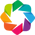

In [15]:
import geoviews as gv
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import rasterize, rd

hv.extension('bokeh')

To simplify the exploration of the time required to display different data, define a function that accepts a regular `pandas` dataframe or a `dask` delayed dataframe. 

In [16]:
def plot(data, **kwargs):
    """Plot point elevation data, rasterizing by mean elevation"""
    points = hv.Points(data, kdims=['meterswest', 'metersnorth'], vdims=['Z'])
    image_opts = opts.Image(tools=['hover'], cmap='blues_r', colorbar=True,
                            width=800, height=800, xaxis=None, yaxis=None)
    return rasterize(points, aggregator=rd.mean('Z'), precompute=True, **kwargs).options(image_opts)

We'll also declare a tiler to use for background imagery.

In [17]:
tiles = gv.tile_sources.EsriImagery()

Then we will construct the plot out of rasterized point data and tiles. 

In [18]:
tiles * plot(small_dataset)

:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [meterswest,metersnorth]   (meterswest_metersnorth Z)

### Benchmarking

In [19]:
%%time
tiles * plot(small_dataset)

CPU times: user 8.6 ms, sys: 53 µs, total: 8.66 ms
Wall time: 8.64 ms


:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [meterswest,metersnorth]   (meterswest_metersnorth Z)

In [20]:
%%time
tiles * plot(dataset)

CPU times: user 8.99 ms, sys: 0 ns, total: 8.99 ms
Wall time: 8.89 ms


:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [meterswest,metersnorth]   (meterswest_metersnorth Z)

In [21]:
%%time
tiles * plot(df_merc)

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 11.4 ms


:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [meterswest,metersnorth]   (meterswest_metersnorth Z)

## Visualize Raster of Point Data

If we compute a raster of the point data then we don't need to store as much data in memory, which should allow faster interactions, and allow use with lots of other tools. 

In [22]:
%%time
raster = plot(dataset, dynamic=False, width=1000, height=1000).data

CPU times: user 2 s, sys: 689 ms, total: 2.69 s
Wall time: 7.98 s


The result is an `xarray.Dataset` with x and y coordinates and a 2D array of Z values.

In [23]:
raster.metersnorth[1] - raster.metersnorth[0]

<xarray.DataArray 'metersnorth' ()>
array(10.29223724)

With these data we can use the geo tools in datashader to compute and visualize the elevation using hillshading for instance. See [Datashader User Guide #8](https://github.com/pyviz/datashader/blob/main/examples/user_guide/8_Geography.ipynb) for more datashader and xrspatial geo tooling. 

In [24]:
from xrspatial import hillshade

In [25]:
illuminated = hillshade(raster.get('meterswest_metersnorth Z'))
hv_shaded = hv.Image((raster.meterswest, raster.metersnorth, illuminated))

In [26]:
tiles * rasterize(hv_shaded.options(opts.Image(cmap='blues', height=600, width=600)))

:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (z)

## Ideas for future work

It'd be nice to have a `rasterio` writer from `xarray` so that we could easily write chunked geotiffs from `xarray` objects.

Something like:

```python
raster.to_rasterio(path=None, mode='w', compute=True)
```